In [35]:
import psycopg2
from scipy import stats as kl
import math
import numpy as np

In [36]:
dimension_attributes = ['workclass','education','education_num','relationship','occupation','race','sex','native_country','salary_range']
measure_attributes = ['age','capital_gain','capital_loss','hours_per_week']
aggregate_functions = ['sum', 'avg', 'max', 'min', 'count']

In [37]:
conn = psycopg2.connect()

In [38]:
def generate_views():
    
    aggregate_views = []
    for a in dimension_attributes:
        for m in measure_attributes:
            for f in aggregate_functions:
                aggregate_views.append((a,m,f))
    return aggregate_views

def normalize(qResult1, qResult2):
    
    dict1 = {}
    dict2 = {}
    
    for i in qResult1:
        
        dict1[i] = float(qResult1[i])
        if i not in qResult2:
            dict2[i] = 1e-10
        else:
            dict2[i] = float(qResult2[i])
        
    for i in qResult2:
        
        if i not in dict1:
            dict1[i] = 1e-10
        
        if i not in dict2:
            dict2[i] = float(qResult2[i])
        
    for i in dict1:
        if(dict1[i] == 0):
            dict1[i] = 1e-10
    
    for i in dict2:
        if(dict2[i] == 0):
            dict2[i] = 1e-10

    if(sum(dict1.values())!=0):
        factor=1.0/sum(dict1.values())
        for k in dict1:
            dict1[k] = dict1[k]*factor
    if(sum(dict2.values())!=0):
        factor=1.0/sum(dict2.values())
        for k in dict2:
            dict2[k] = dict2[k]*factor
    
    return dict1, dict2
    
def calc_utility(res1, res2):
    
    temp1 = []
    temp2 = []
    
    for i in res1:
        temp1.append(res1[i])
    
    for i in res2:
        temp2.append(res2[i])
        
    return kl.entropy(temp1, temp2)
    

def execute(target_view, reference_view):
    
    cur1 = conn.cursor()
    cur2 = conn.cursor()
    
    cur1.execute(target_view)
    cur2.execute(reference_view)
    
    res1, res2 = normalize(dict(cur1.fetchall()), dict(cur2.fetchall()))
    
    return calc_utility(res1, res2)
    
    
def execute_queries(aggregate_views):
    
    results = []
    for a,m,f in aggregate_views:
        target_view = 'select ' + a +', ' + f + '(' + m + ')' + ' from married_adults3 group by ' + a + ';'
        reference_view = 'select ' + a +',' + f + '(' + m + ')' + 'from unmarried_adults3 group by ' + a + ';'
        utility_measure = execute(target_view, reference_view)
        results.append([(a,m,f), utility_measure])
    return results

def get_topK(results, k):
    results.sort(key = lambda x: x[1], reverse = True)
    return results[0:k]

In [39]:
k = 9
aggregate_views = generate_views()
results = execute_queries(aggregate_views)
topK_results = get_topK(results, k)


In [40]:
import pandas as pd

def visualize_query(a, m, f):
    
    target_view = 'select ' + a +', ' + f + '(' + m + ')' + ' from married_adults3 group by ' + a + ';'
    reference_view = 'select ' + a +', ' + f + '(' + m + ')' + 'from unmarried_adults3 group by ' + a + ';'
    
    cur1 = conn.cursor()
    cur2 = conn.cursor()
    
    cur1.execute(target_view)
    cur2.execute(reference_view)
    #print(cur1.fetchall())
    #print(cur2.fetchall())
    df1 = pd.DataFrame(cur1.fetchall(), columns = ["col1","col2"])
    df2 = pd.DataFrame(cur2.fetchall(), columns = ["col1", "col2"])
    joined_df = pd.DataFrame.merge(df1, df2, how = 'outer', on = 'col1', suffixes = ['_married', '_unmarried'])
    joined_df.fillna(0, inplace = True)
    
    df_bar = pd.DataFrame({'married': list(joined_df["col2_married"]), 'unmarried':list(joined_df["col2_unmarried"])}, index = list(joined_df["col1"]))
   
    df_bar['married']=df_bar['married'].astype(float)
    df_bar['unmarried']=df_bar['unmarried'].astype(float)
    ax = df_bar.plot.bar(xlabel = a, ylabel = f + '('+ m +')',rot=60)
   
    

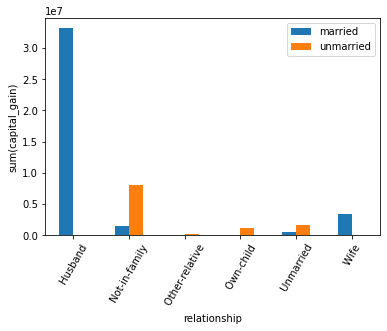

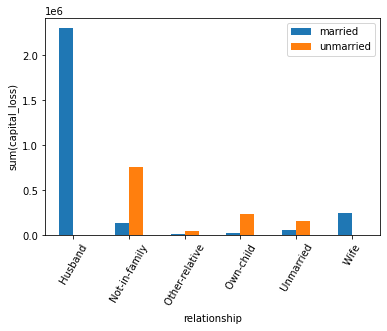

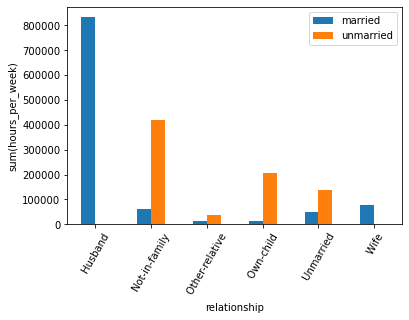

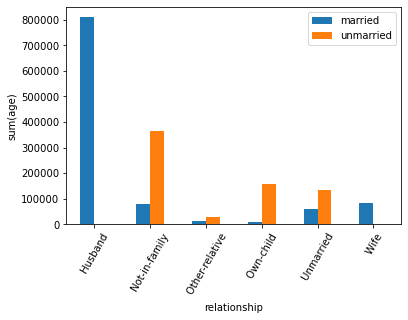

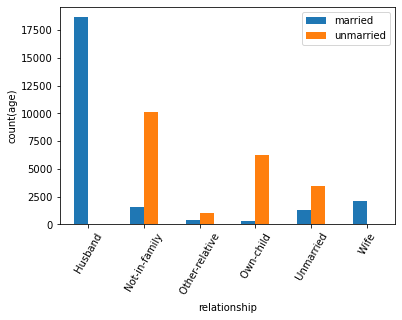

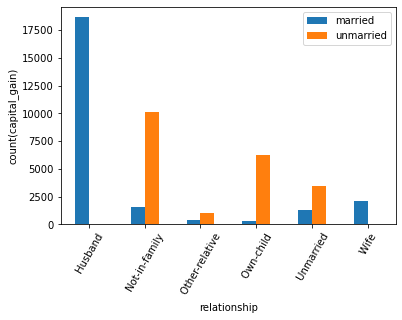

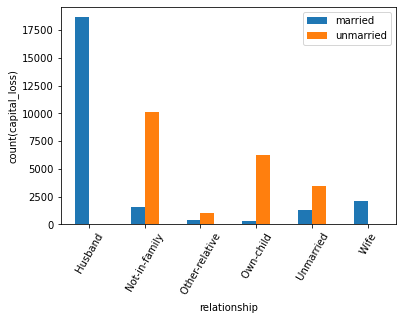

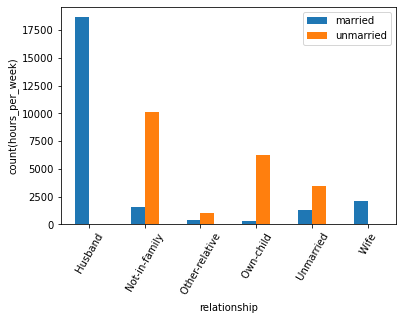

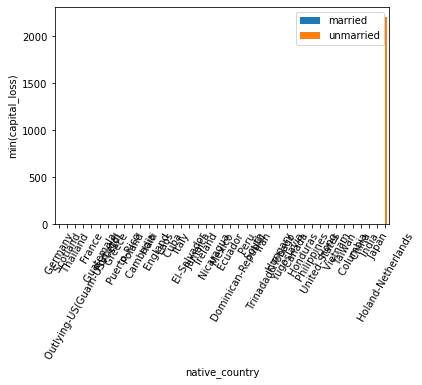

In [41]:
for row in topK_results:
    visualize_query(row[0][0], row[0][1], row[0][2])

In [42]:
def sharing_based_execution(views):
    
    # For a particular groupby(a) combine all measure attributes
    
    groupby_dict = {}
    
    results = []
    
    for a, m, f in views:
        
        if a not in groupby_dict:
            groupby_dict[a] = []
        
        groupby_dict[a].append(f + "(" + m + ")")
    
    for a in groupby_dict:
        
        temp = ','.join(groupby_dict[a])
        target_view = "select "+ a +", " + temp +" from married_adults3 group by " + a + ';'
        reference_view = "select "+ a +", " + temp +" from unmarried_adults3 group by " + a + ';'
        
        cur1 = conn.cursor()
        cur2 = conn.cursor()
    
        cur1.execute(target_view)
        cur2.execute(reference_view)
        
        temp_target_output = cur1.fetchall()
        temp_ref_output = cur2.fetchall()
        for i in range(1, len(groupby_dict[a])+1):
            
            target_output = []
            reference_output = []
            
            for j in range(0, len(temp_target_output)):
                
                target_output.append((temp_target_output[j][0], temp_target_output[j][i]))
                
            for j in range(0, len(temp_ref_output)):
                
                reference_output.append((temp_ref_output[j][0], temp_ref_output[j][i]))
            
            res1, res2 = normalize(dict(target_output), dict(reference_output))
    
            utility_measure = calc_utility(res1, res2)
            
            if(math.isnan(utility_measure) or math.isinf(utility_measure)):
                continue
                
            #groupby_dict[a][i]
            ind1 = groupby_dict[a][i-1].find('(')
            ind2 = groupby_dict[a][i-1].find(')')
            m = groupby_dict[a][i-1][0:ind1]
            f = groupby_dict[a][i-1][ind1 + 1:ind2]
            results.append([(a,f,m), utility_measure])
            
            
                
    return results
    
    

In [43]:
results = sharing_based_execution(aggregate_views)
print(len(results))
topK_results = get_topK(results, 20)

print(topK_results)

180
[[('relationship', 'capital_gain', 'sum'), 36.483427696011226], [('relationship', 'capital_loss', 'sum'), 33.253602161352596], [('relationship', 'hours_per_week', 'sum'), 31.249411759433144], [('relationship', 'age', 'sum'), 30.13894638557155], [('relationship', 'age', 'count'), 27.469337970775126], [('relationship', 'capital_gain', 'count'), 27.469337970775126], [('relationship', 'capital_loss', 'count'), 27.469337970775126], [('relationship', 'hours_per_week', 'count'), 27.469337970775126], [('native_country', 'capital_loss', 'min'), 26.261387658001308], [('relationship', 'capital_gain', 'avg'), 18.326429017847882], [('relationship', 'capital_gain', 'max'), 15.062942305258655], [('relationship', 'capital_loss', 'avg'), 12.708704785608475], [('native_country', 'capital_loss', 'avg'), 11.34258661730613], [('native_country', 'capital_loss', 'max'), 10.931708611962303], [('relationship', 'hours_per_week', 'max'), 8.943775523463248], [('relationship', 'hours_per_week', 'avg'), 8.92713

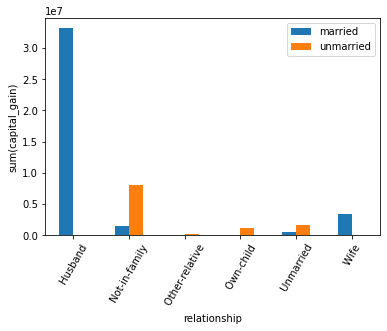

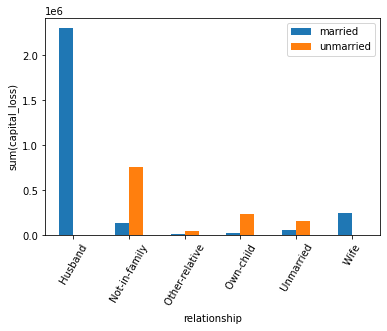

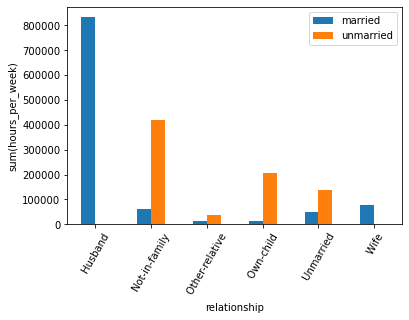

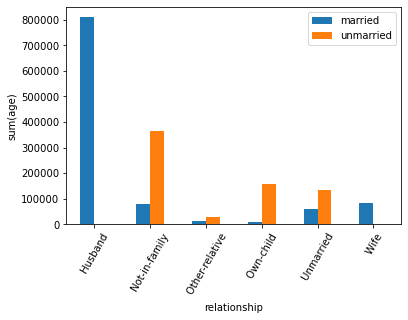

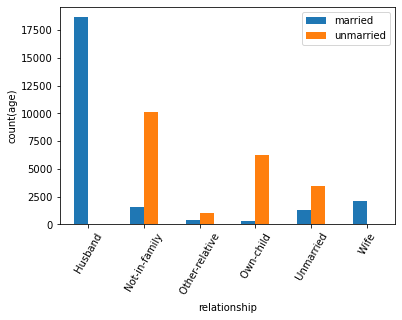

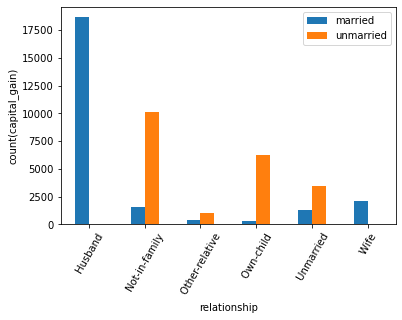

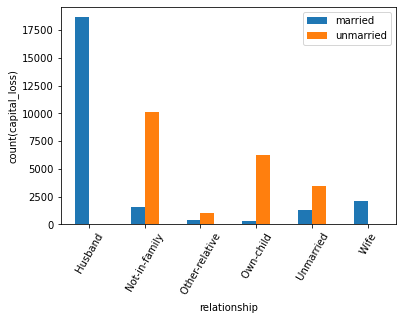

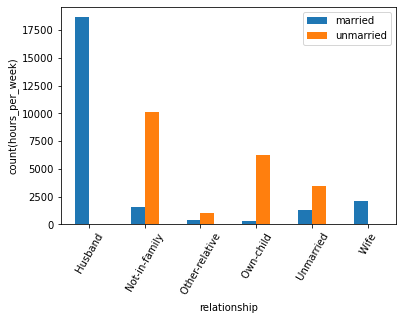

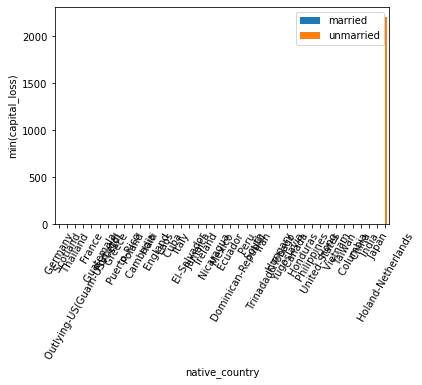

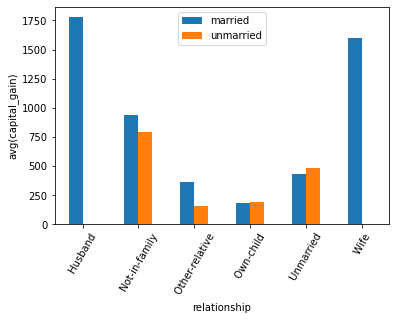

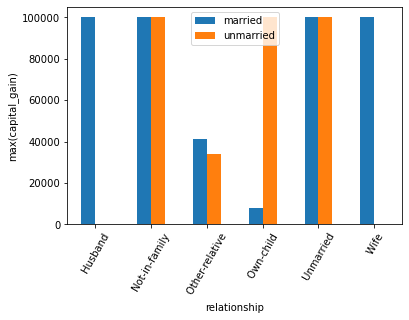

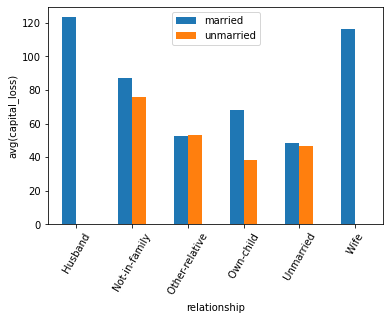

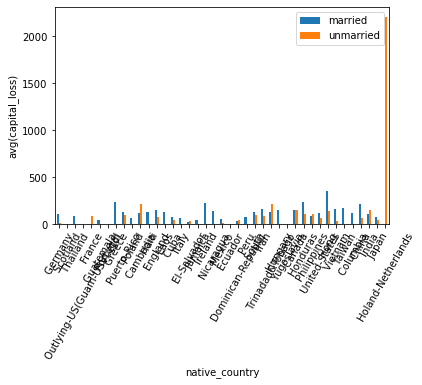

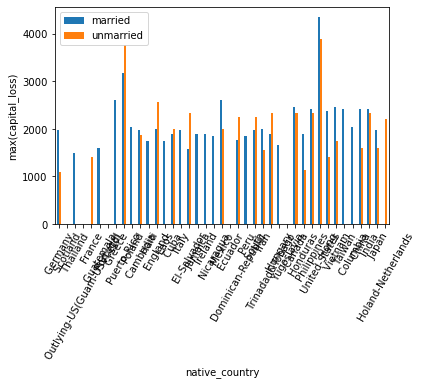

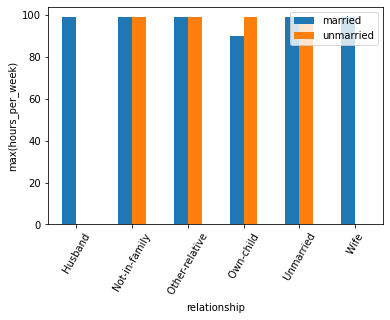

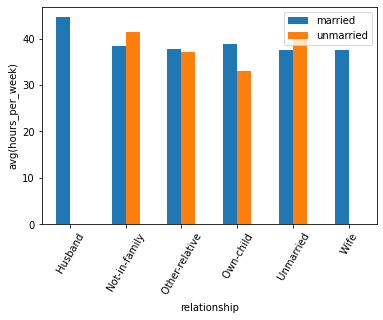

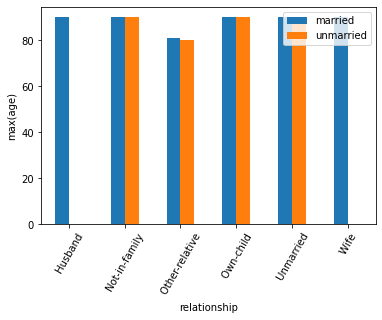

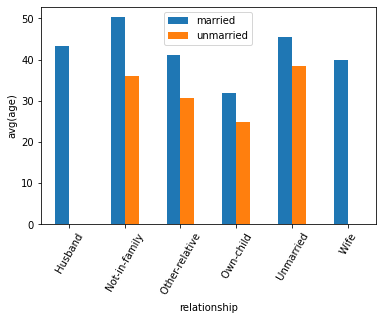

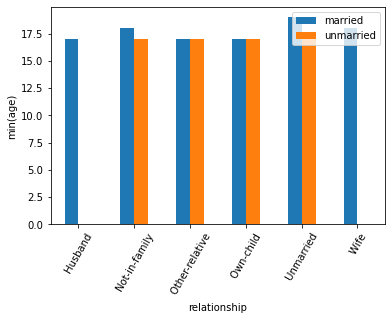

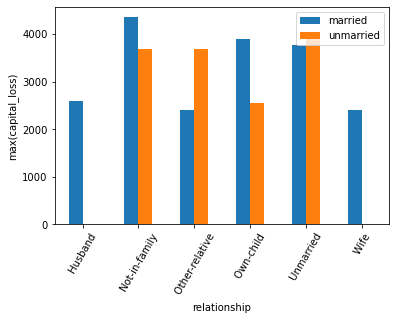

In [44]:
for row in topK_results:
    visualize_query(row[0][0], row[0][1], row[0][2])

In [45]:
n_partitions = 10

for i in range(n_partitions):
    cur = conn.cursor()
    query = """create or replace view s{}_married as 
                   select * from all_adults_{} where marital_status in (' Married-AF-spouse', ' Married-civ-spouse', ' Married-spouse-absent',' Separated');
               create or replace view s{}_unmarried as 
                   select * from all_adults_{} where marital_status in (' Never-married', ' Widowed',' Divorced');""".format(i,i,i,i)
    cur.execute(query)
    conn.commit()
    

In [46]:
def get_pruning_utility(a, m, f, i):
    
    cur1 = conn.cursor()
    cur2 = conn.cursor()
    
    target_view = 'select ' + a +', ' + f + '(' + m + ')' + ' from s' + str(i) + '_married group by ' + a + ';'
    reference_view = 'select ' + a +', ' + f + '(' + m + ')' + ' from s' + str(i) + '_unmarried group by ' + a + ';'
    
    cur1.execute(target_view)
    cur2.execute(reference_view)
    
    res1, res2 = normalize(dict(cur1.fetchall()), dict(cur2.fetchall()))
    return calc_utility(res1, res2)
    
def update_CI(view, running_utility, confidence_intervals, i, delta):
    
    curr_mean = np.mean(running_utility[view])
    m = i+1
    N = 10
    eps =  np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))
    confidence_intervals[view] = [curr_mean - eps, curr_mean + eps]
    
def prune_views(views, k, confidence_intervals):
    
    #print(len(confidence_intervals))
    
    confidence_intervals = dict(sorted(confidence_intervals.items(), key=lambda item: item[1][0], reverse = True))
    ref_bound = list(confidence_intervals.values())[k-1][0]
    
    #print(ref_bound)
    del_views = []
    for view in reversed(confidence_intervals.keys()):
        
        if confidence_intervals[view][1] < ref_bound:
            del_views.append(view)
            if view in views:
                views.remove(view)
            
    for view in del_views:
        confidence_intervals.pop(view)
        

def CI_based_pruning(views, delta, k):
    
    running_utility = {}
    confidence_intervals = {}
    for i in range(n_partitions):
        
        for a, m, f in views:
            
            curr_utility = get_pruning_utility(a, m, f, i)
            
            if (a, m, f) not in running_utility:    
                running_utility[(a, m, f)] = []
                
            running_utility[(a, m, f)].append(curr_utility)
            
            if i >=1:
                update_CI((a, m, f), running_utility, confidence_intervals, i, delta)
        
        if i>=1:
            prune_views(views, k, confidence_intervals)
            
                
pruning_views = generate_views()
CI_based_pruning(pruning_views, 0.05, 20)
print(len(aggregate_views) - len(pruning_views))
    
print(pruning_views)

0
[('workclass', 'age', 'sum'), ('workclass', 'age', 'avg'), ('workclass', 'age', 'max'), ('workclass', 'age', 'min'), ('workclass', 'age', 'count'), ('workclass', 'capital_gain', 'sum'), ('workclass', 'capital_gain', 'avg'), ('workclass', 'capital_gain', 'max'), ('workclass', 'capital_gain', 'min'), ('workclass', 'capital_gain', 'count'), ('workclass', 'capital_loss', 'sum'), ('workclass', 'capital_loss', 'avg'), ('workclass', 'capital_loss', 'max'), ('workclass', 'capital_loss', 'min'), ('workclass', 'capital_loss', 'count'), ('workclass', 'hours_per_week', 'sum'), ('workclass', 'hours_per_week', 'avg'), ('workclass', 'hours_per_week', 'max'), ('workclass', 'hours_per_week', 'min'), ('workclass', 'hours_per_week', 'count'), ('education', 'age', 'sum'), ('education', 'age', 'avg'), ('education', 'age', 'max'), ('education', 'age', 'min'), ('education', 'age', 'count'), ('education', 'capital_gain', 'sum'), ('education', 'capital_gain', 'avg'), ('education', 'capital_gain', 'max'), ('e